# 计算机视觉课程作业
以下任务均在当前image-classifier.ipynb中执行，需要完整执行所有代码，并保存输出结果。完成任务后提交image-classifier.ipynb文件。
### 任务一：提升模型预测准确率
以下代码已经实现了基本的CIFAR-10图像分类。   
在不使用其他预训练模型下（即只能在CIFAR-10数据上从头训练模型），请通过数据增强、模型结构优化、更改优化策略（优化器，epoch，损失函数等）等方式提升模型预测准确率。   
<font color=red>注意：成绩会通过“Step 5: Evaluate model accuracy”的输出结果Average Acc进行评分，请勿更改step 5的代码，且需要完整执行所有代码。</font>

### 任务二：T-SNE
使用pytorch中的hook提取测试集“testloader”在模型中间层的特征表示，并使用T-SNE方法进行可视化。   
<font color=red>注意：可视化结果应当作为"Step 6: T-SNE Visualization"的输出结果。</font>

# 任务一：提升模型预测准确率

>



## Step 1: Download a dataset and preview images

A model is only as good as its dataset.

Training tools need lots of high-quality data to build accurate models. We'll use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 60,000 photos to build our image classifier. Get started by downloading the dataset with `torchvision` and previewing a handful of images from it.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
#import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn
#import bhtsne
from torch.utils.data import DataLoader,Subset
#from sklearn.manifold import TSNE

/opt/conda/envs/SST5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download the CIFAR-10 dataset to ./data
batch_size=32
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                ])
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# for i in range(20):
#     # Add new subplot
#     plt.subplot(2, 10, i + 1)
#     # Plot the image
#     img = images[i]
#     img = img / 2 + 0.5
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)),vmin=0,vmax=255)
#     plt.axis('off')
#     # Add the image's label
#     plt.title(classes[labels[i]])

# plt.suptitle('Preview of Training Data', size=20)
# plt.show()

Files already downloaded and verified
Files already downloaded and verified


# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [4]:
class BasicBlock(nn.Module):

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
            nn.Dropout(0.2)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion),
                nn.Dropout(0.2)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Linear(512 * block.expansion, num_classes),
                                nn.ReLU(),
                                nn.Dropout(0.2) )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():

    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():

    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():

    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():

    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():

    return ResNet(BottleNeck, [3, 8, 36, 3])

class BasicResidualSEBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride, r=16):
        super().__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Conv2d(out_channels, out_channels * self.expansion, 3, padding=1),
            nn.BatchNorm2d(out_channels * self.expansion),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, 1, stride=stride),
                nn.BatchNorm2d(out_channels * self.expansion),
                nn.Dropout(0.2)
            )

        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(out_channels * self.expansion, out_channels * self.expansion // r),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels * self.expansion // r, out_channels * self.expansion),
            nn.Sigmoid(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        shortcut = self.shortcut(x)
        residual = self.residual(x)

        squeeze = self.squeeze(residual)
        squeeze = squeeze.view(squeeze.size(0), -1)
        excitation = self.excitation(squeeze)
        excitation = excitation.view(residual.size(0), residual.size(1), 1, 1)

        x = residual * excitation.expand_as(residual) + shortcut

        return F.relu(x)

class BottleneckResidualSEBlock(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride, r=16):
        super().__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Conv2d(out_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Conv2d(out_channels, out_channels * self.expansion, 1),
            nn.BatchNorm2d(out_channels * self.expansion),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(out_channels * self.expansion, out_channels * self.expansion // r),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels * self.expansion // r, out_channels * self.expansion),
            nn.Sigmoid(),
            nn.Dropout(0.2)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, 1, stride=stride),
                nn.BatchNorm2d(out_channels * self.expansion),
                nn.Dropout(0.2)
            )

    def forward(self, x):

        shortcut = self.shortcut(x)

        residual = self.residual(x)
        squeeze = self.squeeze(residual)
        squeeze = squeeze.view(squeeze.size(0), -1)
        excitation = self.excitation(squeeze)
        excitation = excitation.view(residual.size(0), residual.size(1), 1, 1)

        x = residual * excitation.expand_as(residual) + shortcut

        return F.relu(x)

class SEResNet(nn.Module):

    def __init__(self, block, block_num, class_num=100):
        super().__init__()

        self.in_channels = 64

        self.pre = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.stage1 = self._make_stage(block, block_num[0], 64, 1)
        self.stage2 = self._make_stage(block, block_num[1], 128, 2)
        self.stage3 = self._make_stage(block, block_num[2], 256, 2)
        self.stage4 = self._make_stage(block, block_num[3], 512, 2)

        self.linear =nn.Sequential( nn.Linear(self.in_channels, class_num),
                                   nn.Dropout(0.2))

    def forward(self, x):
        x = self.pre(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)

        x = self.linear(x)

        return x


    def _make_stage(self, block, num, out_channels, stride):

        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion

        while num - 1:
            layers.append(block(self.in_channels, out_channels, 1))
            num -= 1

        return nn.Sequential(*layers)

def seresnet18():
    return SEResNet(BasicResidualSEBlock, [2, 2, 2, 2])

def seresnet34():
    return SEResNet(BasicResidualSEBlock, [3, 4, 6, 3])

def seresnet50():
    return SEResNet(BottleneckResidualSEBlock, [3, 4, 6, 3])

def seresnet101():
    return SEResNet(BottleneckResidualSEBlock, [3, 4, 23, 3])

def seresnet152():
    return SEResNet(BottleneckResidualSEBlock, [3, 8, 36, 3])


net = seresnet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0008, weight_decay=1e-5)

# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [5]:


EPOCHS = 300
patience = 30
PATH = './cifar_net.pth'
print("Training...")
#device = "cuda:3" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(device)
model = net.to(device)
stale = 0
best_acc = 0
alpha = 1.0

def flip(x, dim):
    indices = [slice(None)] * x.dim()
    indices[dim] = torch.arange(x.size(dim) - 1, -1, -1,
                                dtype=torch.long, device=x.device)
    return x[tuple(indices)]

for epoch in range(EPOCHS):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(trainloader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)
        lam = np.random.beta(alpha, alpha)
        index = torch.randperm(imgs.size(0))
        images_a, images_b = imgs, imgs[index]
        labels_a, labels_b = labels, labels[index]
        mixed_images = lam * images_a + (1 - lam) * images_b
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(mixed_images.to(device))
        print(type(imgs))
        print(type(labels))
        print(logits.shape)
        print(labels.shape)
        # logits = model(imgs.to(device))
        # loss = criterion(logits,labels.to(device))
        loss = lam * criterion(logits, labels_a.to(device)) + (1 - lam) * criterion(logits, labels_b.to(device))
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{EPOCHS:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(testloader):

        # A batch consists of image data and corresponding labels.
        
        imgs, labels = batch
        imgs_flip = flip(imgs,2)
        img = imgs.numpy()
        img[0] = cv2.blur(img[0], (3, 3))
        imgs_blur = torch.from_numpy(img.copy())
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits_origin = model(imgs.to(device))
            logits_flip = model(imgs_flip.to(device))
            logits_blur = model(imgs_blur.to(device))
            logits = 0.5 * logits_origin + 0.25 * logits_flip+ 0.25 * logits_blur
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{EPOCHS:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(net.state_dict(), PATH)
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

Training...
cpu


  0%|          | 0/1563 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  0%|          | 1/1563 [00:00<17:47,  1.46it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  0%|          | 2/1563 [00:01<13:11,  1.97it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  0%|          | 3/1563 [00:01<13:24,  1.94it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  0%|          | 4/1563 [00:02<13:48,  1.88it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  0%|          | 5/1563 [00:02<12:29,  2.08it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  0%|          | 6/1563 [00:02<11:27,  2.27it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  0%|          | 7/1563 [00:03<10:55,  2.37it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  1%|          | 8/1563 [00:03<10:25,  2.49it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  1%|          | 9/1563 [00:04<10:11,  2.54it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  1%|          | 10/1563 [00:04<09:51,  2.62it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  1%|          | 11/1563 [00:04<09:46,  2.65it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  1%|          | 12/1563 [00:05<09:34,  2.70it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 100])
torch.Size([32])


  1%|          | 12/1563 [00:05<11:44,  2.20it/s]


KeyboardInterrupt: 

# Step 4: Test the trained model

Let's test our model!

In [ ]:
# @title
# Pick random photos from training set
PATH = './cifar_net_try.pth'
device = "cuda:2" if torch.cuda.is_available() else "cpu"
model = net.to(device)
if dataiter == None:
    dataiter = iter(testloader)
images, labels = next(dataiter)

# Load our model
net = seresnet18()
net.load_state_dict(torch.load(PATH))
model = net.to(device)
# Analyze images
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(20):
    # Add new subplot
    plt.subplot(2,10, i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

RuntimeError: Error(s) in loading state_dict for SEResNet:
	Missing key(s) in state_dict: "pre.0.weight", "pre.0.bias", "pre.1.weight", "pre.1.bias", "pre.1.running_mean", "pre.1.running_var", "stage1.0.residual.0.weight", "stage1.0.residual.0.bias", "stage1.0.residual.1.weight", "stage1.0.residual.1.bias", "stage1.0.residual.1.running_mean", "stage1.0.residual.1.running_var", "stage1.0.residual.4.weight", "stage1.0.residual.4.bias", "stage1.0.residual.5.weight", "stage1.0.residual.5.bias", "stage1.0.residual.5.running_mean", "stage1.0.residual.5.running_var", "stage1.0.excitation.0.weight", "stage1.0.excitation.0.bias", "stage1.0.excitation.2.weight", "stage1.0.excitation.2.bias", "stage1.1.residual.0.weight", "stage1.1.residual.0.bias", "stage1.1.residual.1.weight", "stage1.1.residual.1.bias", "stage1.1.residual.1.running_mean", "stage1.1.residual.1.running_var", "stage1.1.residual.4.weight", "stage1.1.residual.4.bias", "stage1.1.residual.5.weight", "stage1.1.residual.5.bias", "stage1.1.residual.5.running_mean", "stage1.1.residual.5.running_var", "stage1.1.excitation.0.weight", "stage1.1.excitation.0.bias", "stage1.1.excitation.2.weight", "stage1.1.excitation.2.bias", "stage2.0.residual.0.weight", "stage2.0.residual.0.bias", "stage2.0.residual.1.weight", "stage2.0.residual.1.bias", "stage2.0.residual.1.running_mean", "stage2.0.residual.1.running_var", "stage2.0.residual.4.weight", "stage2.0.residual.4.bias", "stage2.0.residual.5.weight", "stage2.0.residual.5.bias", "stage2.0.residual.5.running_mean", "stage2.0.residual.5.running_var", "stage2.0.shortcut.0.weight", "stage2.0.shortcut.0.bias", "stage2.0.shortcut.1.weight", "stage2.0.shortcut.1.bias", "stage2.0.shortcut.1.running_mean", "stage2.0.shortcut.1.running_var", "stage2.0.excitation.0.weight", "stage2.0.excitation.0.bias", "stage2.0.excitation.2.weight", "stage2.0.excitation.2.bias", "stage2.1.residual.0.weight", "stage2.1.residual.0.bias", "stage2.1.residual.1.weight", "stage2.1.residual.1.bias", "stage2.1.residual.1.running_mean", "stage2.1.residual.1.running_var", "stage2.1.residual.4.weight", "stage2.1.residual.4.bias", "stage2.1.residual.5.weight", "stage2.1.residual.5.bias", "stage2.1.residual.5.running_mean", "stage2.1.residual.5.running_var", "stage2.1.excitation.0.weight", "stage2.1.excitation.0.bias", "stage2.1.excitation.2.weight", "stage2.1.excitation.2.bias", "stage3.0.residual.0.weight", "stage3.0.residual.0.bias", "stage3.0.residual.1.weight", "stage3.0.residual.1.bias", "stage3.0.residual.1.running_mean", "stage3.0.residual.1.running_var", "stage3.0.residual.4.weight", "stage3.0.residual.4.bias", "stage3.0.residual.5.weight", "stage3.0.residual.5.bias", "stage3.0.residual.5.running_mean", "stage3.0.residual.5.running_var", "stage3.0.shortcut.0.weight", "stage3.0.shortcut.0.bias", "stage3.0.shortcut.1.weight", "stage3.0.shortcut.1.bias", "stage3.0.shortcut.1.running_mean", "stage3.0.shortcut.1.running_var", "stage3.0.excitation.0.weight", "stage3.0.excitation.0.bias", "stage3.0.excitation.2.weight", "stage3.0.excitation.2.bias", "stage3.1.residual.0.weight", "stage3.1.residual.0.bias", "stage3.1.residual.1.weight", "stage3.1.residual.1.bias", "stage3.1.residual.1.running_mean", "stage3.1.residual.1.running_var", "stage3.1.residual.4.weight", "stage3.1.residual.4.bias", "stage3.1.residual.5.weight", "stage3.1.residual.5.bias", "stage3.1.residual.5.running_mean", "stage3.1.residual.5.running_var", "stage3.1.excitation.0.weight", "stage3.1.excitation.0.bias", "stage3.1.excitation.2.weight", "stage3.1.excitation.2.bias", "stage4.0.residual.0.weight", "stage4.0.residual.0.bias", "stage4.0.residual.1.weight", "stage4.0.residual.1.bias", "stage4.0.residual.1.running_mean", "stage4.0.residual.1.running_var", "stage4.0.residual.4.weight", "stage4.0.residual.4.bias", "stage4.0.residual.5.weight", "stage4.0.residual.5.bias", "stage4.0.residual.5.running_mean", "stage4.0.residual.5.running_var", "stage4.0.shortcut.0.weight", "stage4.0.shortcut.0.bias", "stage4.0.shortcut.1.weight", "stage4.0.shortcut.1.bias", "stage4.0.shortcut.1.running_mean", "stage4.0.shortcut.1.running_var", "stage4.0.excitation.0.weight", "stage4.0.excitation.0.bias", "stage4.0.excitation.2.weight", "stage4.0.excitation.2.bias", "stage4.1.residual.0.weight", "stage4.1.residual.0.bias", "stage4.1.residual.1.weight", "stage4.1.residual.1.bias", "stage4.1.residual.1.running_mean", "stage4.1.residual.1.running_var", "stage4.1.residual.4.weight", "stage4.1.residual.4.bias", "stage4.1.residual.5.weight", "stage4.1.residual.5.bias", "stage4.1.residual.5.running_mean", "stage4.1.residual.5.running_var", "stage4.1.excitation.0.weight", "stage4.1.excitation.0.bias", "stage4.1.excitation.2.weight", "stage4.1.excitation.2.bias", "linear.0.weight", "linear.0.bias". 
	Unexpected key(s) in state_dict: "conv1.0.weight", "conv1.1.weight", "conv1.1.bias", "conv1.1.running_mean", "conv1.1.running_var", "conv1.1.num_batches_tracked", "conv2_x.0.residual_function.0.weight", "conv2_x.0.residual_function.1.weight", "conv2_x.0.residual_function.1.bias", "conv2_x.0.residual_function.1.running_mean", "conv2_x.0.residual_function.1.running_var", "conv2_x.0.residual_function.1.num_batches_tracked", "conv2_x.0.residual_function.3.weight", "conv2_x.0.residual_function.4.weight", "conv2_x.0.residual_function.4.bias", "conv2_x.0.residual_function.4.running_mean", "conv2_x.0.residual_function.4.running_var", "conv2_x.0.residual_function.4.num_batches_tracked", "conv2_x.1.residual_function.0.weight", "conv2_x.1.residual_function.1.weight", "conv2_x.1.residual_function.1.bias", "conv2_x.1.residual_function.1.running_mean", "conv2_x.1.residual_function.1.running_var", "conv2_x.1.residual_function.1.num_batches_tracked", "conv2_x.1.residual_function.3.weight", "conv2_x.1.residual_function.4.weight", "conv2_x.1.residual_function.4.bias", "conv2_x.1.residual_function.4.running_mean", "conv2_x.1.residual_function.4.running_var", "conv2_x.1.residual_function.4.num_batches_tracked", "conv3_x.0.residual_function.0.weight", "conv3_x.0.residual_function.1.weight", "conv3_x.0.residual_function.1.bias", "conv3_x.0.residual_function.1.running_mean", "conv3_x.0.residual_function.1.running_var", "conv3_x.0.residual_function.1.num_batches_tracked", "conv3_x.0.residual_function.3.weight", "conv3_x.0.residual_function.4.weight", "conv3_x.0.residual_function.4.bias", "conv3_x.0.residual_function.4.running_mean", "conv3_x.0.residual_function.4.running_var", "conv3_x.0.residual_function.4.num_batches_tracked", "conv3_x.0.shortcut.0.weight", "conv3_x.0.shortcut.1.weight", "conv3_x.0.shortcut.1.bias", "conv3_x.0.shortcut.1.running_mean", "conv3_x.0.shortcut.1.running_var", "conv3_x.0.shortcut.1.num_batches_tracked", "conv3_x.1.residual_function.0.weight", "conv3_x.1.residual_function.1.weight", "conv3_x.1.residual_function.1.bias", "conv3_x.1.residual_function.1.running_mean", "conv3_x.1.residual_function.1.running_var", "conv3_x.1.residual_function.1.num_batches_tracked", "conv3_x.1.residual_function.3.weight", "conv3_x.1.residual_function.4.weight", "conv3_x.1.residual_function.4.bias", "conv3_x.1.residual_function.4.running_mean", "conv3_x.1.residual_function.4.running_var", "conv3_x.1.residual_function.4.num_batches_tracked", "conv4_x.0.residual_function.0.weight", "conv4_x.0.residual_function.1.weight", "conv4_x.0.residual_function.1.bias", "conv4_x.0.residual_function.1.running_mean", "conv4_x.0.residual_function.1.running_var", "conv4_x.0.residual_function.1.num_batches_tracked", "conv4_x.0.residual_function.3.weight", "conv4_x.0.residual_function.4.weight", "conv4_x.0.residual_function.4.bias", "conv4_x.0.residual_function.4.running_mean", "conv4_x.0.residual_function.4.running_var", "conv4_x.0.residual_function.4.num_batches_tracked", "conv4_x.0.shortcut.0.weight", "conv4_x.0.shortcut.1.weight", "conv4_x.0.shortcut.1.bias", "conv4_x.0.shortcut.1.running_mean", "conv4_x.0.shortcut.1.running_var", "conv4_x.0.shortcut.1.num_batches_tracked", "conv4_x.1.residual_function.0.weight", "conv4_x.1.residual_function.1.weight", "conv4_x.1.residual_function.1.bias", "conv4_x.1.residual_function.1.running_mean", "conv4_x.1.residual_function.1.running_var", "conv4_x.1.residual_function.1.num_batches_tracked", "conv4_x.1.residual_function.3.weight", "conv4_x.1.residual_function.4.weight", "conv4_x.1.residual_function.4.bias", "conv4_x.1.residual_function.4.running_mean", "conv4_x.1.residual_function.4.running_var", "conv4_x.1.residual_function.4.num_batches_tracked", "conv5_x.0.residual_function.0.weight", "conv5_x.0.residual_function.1.weight", "conv5_x.0.residual_function.1.bias", "conv5_x.0.residual_function.1.running_mean", "conv5_x.0.residual_function.1.running_var", "conv5_x.0.residual_function.1.num_batches_tracked", "conv5_x.0.residual_function.3.weight", "conv5_x.0.residual_function.4.weight", "conv5_x.0.residual_function.4.bias", "conv5_x.0.residual_function.4.running_mean", "conv5_x.0.residual_function.4.running_var", "conv5_x.0.residual_function.4.num_batches_tracked", "conv5_x.0.shortcut.0.weight", "conv5_x.0.shortcut.1.weight", "conv5_x.0.shortcut.1.bias", "conv5_x.0.shortcut.1.running_mean", "conv5_x.0.shortcut.1.running_var", "conv5_x.0.shortcut.1.num_batches_tracked", "conv5_x.1.residual_function.0.weight", "conv5_x.1.residual_function.1.weight", "conv5_x.1.residual_function.1.bias", "conv5_x.1.residual_function.1.running_mean", "conv5_x.1.residual_function.1.running_var", "conv5_x.1.residual_function.1.num_batches_tracked", "conv5_x.1.residual_function.3.weight", "conv5_x.1.residual_function.4.weight", "conv5_x.1.residual_function.4.bias", "conv5_x.1.residual_function.4.running_mean", "conv5_x.1.residual_function.4.running_var", "conv5_x.1.residual_function.4.num_batches_tracked", "fc.weight", "fc.bias". 

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [ ]:
# @title
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
average_accuray = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    average_accuray.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print ('Average Acc:', np.mean(average_accuray))

Accuracy for class: plane is 75.1 %
Accuracy for class: car   is 81.8 %
Accuracy for class: bird  is 74.0 %
Accuracy for class: cat   is 69.7 %
Accuracy for class: deer  is 76.7 %
Accuracy for class: dog   is 67.5 %
Accuracy for class: frog  is 74.0 %
Accuracy for class: horse is 73.5 %
Accuracy for class: ship  is 76.8 %
Accuracy for class: truck is 76.4 %
Average Acc: 74.54999999999998


# 任务二：T-SNE

# Step 6: T-SNE Visualization

Visualize high-dimensional data in a low-dimensional space using T-SNE.

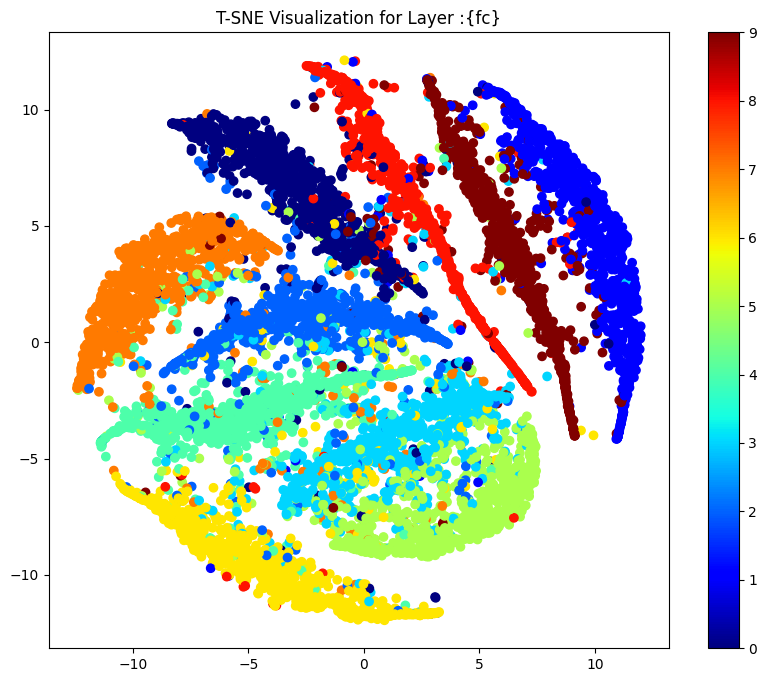

In [ ]:
net = seresnet152()
PATH_show = './cifar_net.pth'
device = "cuda:2" if torch.cuda.is_available() else "cpu"
net.load_state_dict(torch.load(PATH_show))
model = net.to(device)

subset_size = 10000
subset_indices = range(subset_size)
subset_test_dataset = Subset(testset,subset_indices)
subset_test_loader = DataLoader(subset_test_dataset , batch_size = 64, shuffle=False)
def hook_fn(module, input, output):
    features.append(output)

target_layer = model.linear  

hook = target_layer.register_forward_hook(hook_fn)
ture_matrix = []
labels=[]
features = []
feature_matrix=[]
with torch.no_grad():
    for data in subset_test_loader:
        inputs, batch_label = data
        inputs = inputs.to(device)
        model(inputs)
        labels.extend(batch_label)
        feature_matrix.append(torch.cat(features, dim=1).view(features[0].size(0),-1))
        features = []

hook.remove()

feature_matrix = torch.cat(feature_matrix,dim=0).cpu().numpy()



tsne = TSNE(n_components=2,perplexity=30,n_iter=300,learning_rate=200.0)
tsne_features = tsne.fit_transform(feature_matrix)


plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels ,cmap='jet')
plt.colorbar()
plt.title('T-SNE Visualization for Layer :{fc}')
plt.show()